Rafael Gonçalves (186062)

In [1]:
import os
import urllib.request
import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from mlxtend.plotting import plot_decision_regions

%matplotlib inline

## Download dataset

In [2]:
train_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_treinamento.mat'
validation_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_val.mat'
test_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_teste.mat'
data_dir = os.path.abspath(os.path.relpath('../data'))
train_path = os.path.join(data_dir, 'train.mat')
validation_path = os.path.join(data_dir, 'validation.mat')
test_path = os.path.join(data_dir, 'test.mat')
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

urllib.request.urlretrieve(train_url, train_path)
urllib.request.urlretrieve(validation_url, validation_path)
urllib.request.urlretrieve(test_url, test_path)

('/home/rafael/inbox/machine-learning/3-mlp-and-svm/data/test.mat',
 <http.client.HTTPMessage at 0x7f96e056acc0>)

In [3]:
train_set = scipy.io.loadmat(train_path)
val_set = scipy.io.loadmat(validation_path)
test_set = scipy.io.loadmat(test_path)

In [4]:
X_train = train_set["X"]
y_train = train_set["y"]
X_val = val_set["Xval"]
y_val = val_set["yval"]
X_test = test_set["Xt"]
y_test = test_set["yt"]

In [5]:
y_train[y_train == -1] = 0
y_val[y_val == -1] = 0
y_test[y_test == -1] = 0

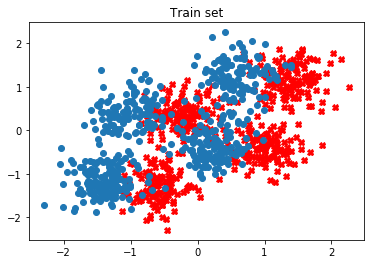

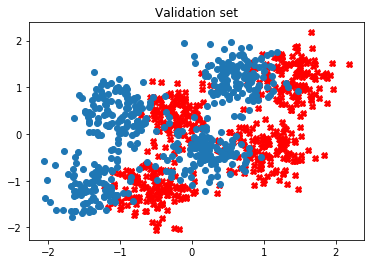

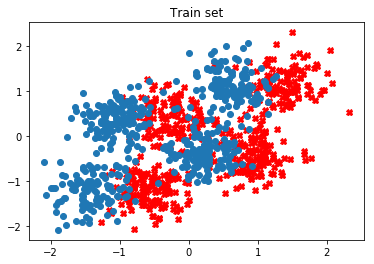

In [6]:
plt.plot(X_train[np.in1d(y_train, 1), 0], X_train[np.in1d(y_train, 1), 1], 'rX')
plt.plot(X_train[np.in1d(y_train, 0), 0], X_train[np.in1d(y_train, 0), 1], 'o')
plt.title("Train set")
plt.savefig(os.path.join(image_dir, 'train_set.png'), bbox_inches='tight')
plt.show()
plt.plot(X_val[np.in1d(y_val, 1), 0], X_val[np.in1d(y_val, 1), 1], 'rX')
plt.plot(X_val[np.in1d(y_val, 0), 0], X_val[np.in1d(y_val, 0), 1], 'o')
plt.savefig(os.path.join(image_dir, 'validation_set.png'), bbox_inches='tight')
plt.title("Validation set")
plt.show()
plt.title("Train set")
plt.plot(X_test[np.in1d(y_test, 1), 0], X_test[np.in1d(y_test, 1), 1], 'rX')
plt.plot(X_test[np.in1d(y_test, 0), 0], X_test[np.in1d(y_test, 0), 1], 'o')
plt.savefig(os.path.join(image_dir, 'test_set.png'), bbox_inches='tight')

plt.show()

# 1 - Multilayer Perceptron (MLP)

In [7]:
C = 1 # number of classes
D_in = 2 # dimension of input

In [8]:
X_train_t = torch.tensor(X_train, dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.float)
X_val_t = torch.tensor(X_val, dtype=torch.float)
y_val_t = torch.tensor(y_val, dtype=torch.float)
X_test_t = torch.tensor(X_test, dtype=torch.float)
y_test_t = torch.tensor(y_test, dtype=torch.float)

In [ ]:
# batch training
epochs = 10000
show_step = 1000

for H in [3, 6, 10, 30, 60]:
    print("H = ", H)
    train_losses = []
    val_losses = []
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
    )
    
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = F.binary_cross_entropy(output, y_train_t)
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
        
        model.eval()
        with torch.no_grad():
            output = model(X_val_t)
            val_loss = F.binary_cross_entropy(output, y_val_t)
        pred = np.where(output<0.5,0,1)
        correct = y_val_t.eq(torch.tensor(pred, dtype=torch.float)).sum()
        val_losses.append(val_loss)
        if epoch % show_step == 0:
            print('Validation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            val_loss, correct, len(y_val),
            100. * correct / len(y_val)))
        gc.collect()

    
    plt.plot(train_losses, color='blue')
    plt.plot(val_losses, color='red')
    plt.legend(["train", "validation"])
    plt.yscale("log")
    plt.title('Learning curve with {} neurons in hidden layer'.format(H))
    plt.xlabel('number of training examples seen')
    plt.ylabel('cross entropy loss')
    plt.savefig(os.path.join(image_dir, 'batch_curve_h_{}.png'.format(H)), bbox_inches='tight')
    plt.show()

H =  3
Validation set: Avg. loss: 0.6938, Accuracy: 519/1000 (51%)
Validation set: Avg. loss: 0.5611, Accuracy: 664/1000 (66%)
Validation set: Avg. loss: 0.4973, Accuracy: 702/1000 (70%)
Validation set: Avg. loss: 0.4792, Accuracy: 711/1000 (71%)
Validation set: Avg. loss: 0.4736, Accuracy: 715/1000 (71%)


In [ ]:
# online training
epochs = 200
show_step = 20

for H in [3, 6, 10, 30, 60]:
    print("H = ", H)
    train_losses = []
    val_losses = []
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
    )
    
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(epochs):
        model.train()
        for idx, (data, target) in enumerate(zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float))):
            optimizer.zero_grad()
            output = model(data)
            loss = F.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        # if epoch % show_step == 0:
        #    print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
        train_losses.append(loss.item())        
    
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in zip(torch.tensor(X_val, dtype=torch.float),
                                             torch.tensor(y_val, dtype=torch.float)):
                output = model(data)
                val_loss += F.binary_cross_entropy(output, target, size_average=False).item()
                pred = torch.round(output)
                correct += (1 if pred == target else 0)
        val_loss /= len(y_val)
        val_losses.append(val_loss)
        if epoch % show_step == 0:
            print('Validation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                val_loss, correct, len(y_val),
                100. * correct / len(y_val)))
    
    plt.plot(train_losses, color='blue')
    plt.plot(val_losses, color='red')
    plt.legend(["train", "validation"])
    plt.yscale("log")
    plt.title('Learning curve with {} neurons in hidden layer'.format(H))
    plt.xlabel('number of training examples seen')
    plt.ylabel('cross entropy loss')
    plt.savefig(os.path.join(image_dir, 'online_curve_h_{}.png'.format(H)), bbox_inches='tight')
    plt.show()

In [ ]:
epochs = 300
H = 6

model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
)

X = np.vstack((X_train, X_val))
y = np.vstack((y_train, y_val))

optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    model.train()
    for idx, (data, target) in enumerate(zip(torch.tensor(X, dtype=torch.float),
                                     torch.tensor(y, dtype=torch.float))):
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print('.', end='')

In [ ]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in zip(torch.tensor(X_test, dtype=torch.float),
                             torch.tensor(y_test, dtype=torch.float)):
        output = model(data)
        test_loss += F.binary_cross_entropy(output, target, size_average=False).item()
        pred = torch.round(output)
        correct += (1 if pred == target else 0)
    test_loss /= len(y_test)
print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    val_loss, correct, len(y_test),
    100. * correct / len(y_test)))

In [ ]:
# Pass test data
X_test_t = torch.FloatTensor(X_test)
y_hat_test = models[1](X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(y_test.reshape(-1,1)==y_hat_test_class) / len(y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

# Plot the decision boundary
# Determine grid range in x and y directions
x_min, x_max = X_train[:, 0].min()-0.3, X_train[:, 0].max()+0.3
y_min, y_max = X_train[:, 1].min()-0.3, X_train[:, 1].max()+0.3

# Set grid spacing parameter
spacing = min(x_max - x_min, y_max - y_min) / 100

# Create grid
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

# Concatenate data to match input
data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

# Pass data to predict method
data_t = torch.FloatTensor(data)
db_prob = models[1](data_t)

clf = np.where(db_prob<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.title("Decision Regions for MLP with {} neurons in hidden layer".format(H))
plt.contourf(XX, YY, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.plot(X_test[np.in1d(y_test, 1), 0], X_test[np.in1d(y_test, 1), 1], 'rx')
plt.plot(X_test[np.in1d(y_test, 0), 0], X_test[np.in1d(y_test, 0), 1], 'b.')
plt.savefig(os.path.join(image_dir, 'mlp_regions_h_{}.png'.format(H)), bbox_inches='tight')
plt.show()

## 2 - Support-Vector Machine (SVM)

In [ ]:
clf = SVC(gamma='scale')

In [ ]:
clf.fit(X_train, y_train.ravel())

In [ ]:
y_pred = clf.predict(X_val)

In [ ]:
accuracy_score(y_pred, y_val)

In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for c in [1, 10, 50, 100]:
        clf = SVC(C=c, kernel=kernel, gamma='scale')
        clf.fit(X_train, y_train.ravel())
        
        y_pred = clf.predict(X_val)
        ac = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_pred)
        
        print('===')
        print('SVM with C =', c, 'and kernel =', kernel)
        print('Accuracy: {}, F1-score: {:.3f}, AUC: {:.3f}'.format(ac, f1, auc_score))
        
        plot_decision_regions(X_val, y_val.ravel(), clf=clf)
        plt.show()

In [ ]:
clf = SVC(C=50, kernel='rbf', gamma='scale')
clf.fit(X_train, y_train.ravel())

y_pred = clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('===')
print('SVM with C =', 50, 'and kernel =', 'rbf')
print('Accuracy: {}, F1-score: {:.3f}, AUC: {:.3f}'.format(ac, f1, auc_score))

plot_decision_regions(X_test, y_test.ravel(), clf=clf)
plt.show()